In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src/

/tf/notebooks/src


## Intialization

In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Packages

In [4]:
try:
    import pandas
except:
    !pip install pandas iterative-stratification nlpaug==0.0.20 tqdm click tensorflow_probability==0.11.1 tf2_resnets tensorflow_addons==0.11.1 image-classifiers==0.2.2

### Imports

In [5]:
import os
import glob
import click
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter

In [6]:
from params import *
from train import get_model
from params import TEST_MELS_PATH, TRAIN_MELS_PATH

In [7]:
physical_devices = tf.config.list_physical_devices("GPU")
for i in range(len(physical_devices)):
    tf.config.experimental.set_memory_growth(physical_devices[i], True)

tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})

In [8]:
def generate_s_e_window_sliding(sample_len, win_size, step_size):
    start = 0
    end = win_size
    s_e = []
    s_e.append([start, end])
    while end < sample_len:
        start += step_size
        end = start + win_size
        s_e.append([start, end])

    s_e[-1][0] -= s_e[-1][1] - sample_len
    s_e[-1][1] = sample_len
    return s_e

In [9]:
def run_prediction(model_name, df, checkpoints_path, fold, root=TEST_MELS_PATH):
    all_checkpoints = sorted(
        glob.glob(os.path.join(checkpoints_path, f"fold{fold}", "model-*.h5"))
    )

    model = get_model(
        model_name=model_name,
        saved_path=checkpoints_path,
        pretrained_with_contrastive=False,
        pretrained_path=all_checkpoints[-1],
    )
    
    @tf.function(experimental_relax_shapes=True)
    def predict(data):
        out = model(data, training=False)
        return out

    lwlrap_at_scale = np.load(
        os.path.join(CP_FOLDER, f"lwlrap_at_scale_{fold}.npy")
    )  # [24, n_scales]

    scales_to_compute = []
    for c in range(NUM_CLASSES):
        best_score = lwlrap_at_scale[:, c].max()
        best_indexes = [i for i, j in enumerate(lwlrap_at_scale[:, c]) if j == best_score]
        scales_to_compute.append(SCALES[best_indexes[-1]])
    scales_to_compute = sorted(np.unique(scales_to_compute))
    
#     scales_to_compute = [SCALES[i] for i in sorted(np.unique(lwlrap_at_scale.argmax(0)))]
    preds = {}

    for scale in scales_to_compute:
        print(" -> Predicting at scale", scale)
        preds_scale = []
        
        for i in range(len(df)):
            recording_id = df.iloc[i]["recording_id"]
            mel = np.load(os.path.join(root, recording_id + ".npy"))
            
            crops = generate_s_e_window_sliding(len(mel), win_size=scale, step_size=scale)
                
            mel_chunks = [mel[s:e] for (s, e) in crops]
            mel_chunks = np.array(mel_chunks).reshape((-1, scale, NUM_FEATURES, 3))
            
            clip_preds = predict(mel_chunks)  # n_chunks x 24
            
            preds_scale.append(tf.nn.sigmoid(clip_preds).numpy())
        preds[scale] = np.array(preds_scale)  # n_samples x n_chunks x 24
        
        if preds[scale].max() < 0.9:
            print('Warning, low max value.')

    print('\n -> Aggregating predictions')
    
    pred_agg = np.zeros((len(df), NUM_CLASSES))
    preds_multiscale = []
    for c in range(NUM_CLASSES):
        
#         scale_to_use = SCALES[lwlrap_at_scale[:, c].argmax()]
        best_score = lwlrap_at_scale[:, c].max()
        best_indexes = [i for i, j in enumerate(lwlrap_at_scale[:, c]) if j == best_score]
        scale_to_use = SCALES[best_indexes[-1]]
        
        pred_class = preds[scale_to_use][:, :, c]
        preds_multiscale.append(pred_class)
        pred_agg[:, c] = pred_class.max(-1)

    return pred_agg, preds_multiscale

In [10]:
def preds_to_pl(df, cp_folders, root="preds"):
    crops = []
    for scale in SCALES:
        crops.append(generate_s_e_window_sliding(SPEC_LENGTH, win_size=scale, step_size=scale))
        
    final_preds = []
    for cp_folder in tqdm(cp_folders):

        
        all_preds = []
        for fold_idx in range(5):
            preds = np.zeros((len(df), SPEC_LENGTH, NUM_CLASSES))

            for c in range(NUM_CLASSES):
                pred = np.load(cp_folder + f"{root}/pred_multiscale_{fold_idx}_{c}.npy")

                associated_crops = [c for c in crops if len(c) == len(pred[0])][0]

                for i in range(len(df)):
                    for crop in range(len(associated_crops)):
                        start, end = associated_crops[crop][0], associated_crops[crop][1]
                        preds[i, start:end, c] = pred[i][crop]

            all_preds.append(preds)
        all_preds = np.mean(all_preds, 0)
        print(all_preds.shape)
        final_preds.append(all_preds)
    return final_preds

# Main

In [11]:
CP_FOLDER = LOG_PATH + "2021-02-04/9/"
CP_FOLDER = LOG_PATH + "2021-02-04/12/"

In [12]:
MODELS = [
    'densenet121',
    'resnet18',
    'resnet34',
    'resnext50',
    'efficientnetb2',
    "xception",
    'resnest50',
    'efficientnetb3',
]

In [13]:
CP_FOLDERS = [
    "../logs/2021-02-16/1/",
#     LOG_PATH + "2021-02-04/9/",
#     "../logs/2021-02-14/8/",
#     "../logs/2021-02-14/9/",
#     "../logs/2021-02-14/10/",
#     "../logs/2021-02-15/0/",
#     "../logs/2021-02-15/1/",
#     "../logs/2021-02-15/2/",
#     "../logs/2021-02-15/3/",
]

## Test

In [14]:
df_test = pd.read_csv(DATA_PATH + "sample_submission.csv")

In [16]:
for model_name, CP_FOLDER in zip(MODELS, CP_FOLDERS):
    
    print(f'\n########################\n -> Log folder : {CP_FOLDER}\n########################\n')
    
    save_folder = CP_FOLDER + "preds/"
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)

    for fold_idx in range(5):
        tf.keras.backend.clear_session()
        print(f"\n-------------   Fold {fold_idx + 1} / {5}  -------------\n")

        pred_agg, preds_multiscale = run_prediction(model_name, df_test, CP_FOLDER, fold_idx)

        np.save(save_folder + f"pred_agg_{fold_idx}.npy", pred_agg)
        for c, preds in enumerate(preds_multiscale):
            np.save(save_folder + f"pred_multiscale_{fold_idx}_{c}.npy", preds)


########################
 -> Log folder : ../logs/2021-02-16/1/
########################


-------------   Fold 1 / 5  -------------

 -> Loading weights from ../logs/2021-02-16/1/fold0/model-0.820-0.130.h5

 -> Predicting at scale 32
 -> Predicting at scale 64
 -> Predicting at scale 192
 -> Predicting at scale 256
 -> Predicting at scale 320
 -> Predicting at scale 384
 -> Predicting at scale 448
 -> Predicting at scale 512

 -> Aggregating predictions

-------------   Fold 2 / 5  -------------

 -> Loading weights from ../logs/2021-02-16/1/fold1/model-0.860-0.116.h5

 -> Predicting at scale 32
 -> Predicting at scale 64
 -> Predicting at scale 192
 -> Predicting at scale 256
 -> Predicting at scale 320
 -> Predicting at scale 384
 -> Predicting at scale 448
 -> Predicting at scale 512

 -> Aggregating predictions

-------------   Fold 3 / 5  -------------

 -> Loading weights from ../logs/2021-02-16/1/fold2/model-0.796-0.125.h5

 -> Predicting at scale 32
 -> Predicting at scale 64

In [16]:
preds = preds_to_pl(df_test, CP_FOLDERS)


  0%|          | 0/8 [00:00<?, ?it/s]

(1992, 3001, 24)
(1992, 3001, 24)
(1992, 3001, 24)
(1992, 3001, 24)
(1992, 3001, 24)
(1992, 3001, 24)
(1992, 3001, 24)
(1992, 3001, 24)


In [21]:
def clever_blend(preds, threshold=0.9):
    blend = np.zeros(preds[0].shape)
    count = np.zeros((1, 1, NUM_CLASSES))
    
    maxs = np.array([pred.max(0).max(0) for pred in preds])
    use_for_blend = (maxs > threshold).astype(int)
    use_for_blend = use_for_blend == 1
    
    for i in range(len(preds)):
        for c in range(NUM_CLASSES):
            if use_for_blend[i, c]:
                count[:, :, c] += 1
                blend[:, :, c] += preds[i][:, :, c]
            else:
                print(f'Pred {i} : Not using class {c}')
    
    return blend / count

In [22]:
final_pl = clever_blend(preds)

Pred 1 : Not using class 3
Pred 4 : Not using class 3
Pred 4 : Not using class 18
Pred 4 : Not using class 21
Pred 6 : Not using class 3
Pred 6 : Not using class 7
Pred 6 : Not using class 18
Pred 6 : Not using class 21
Pred 7 : Not using class 3
Pred 7 : Not using class 18
Pred 7 : Not using class 21


In [23]:
np.save(f"../output/pl_test.npy", final_pl)

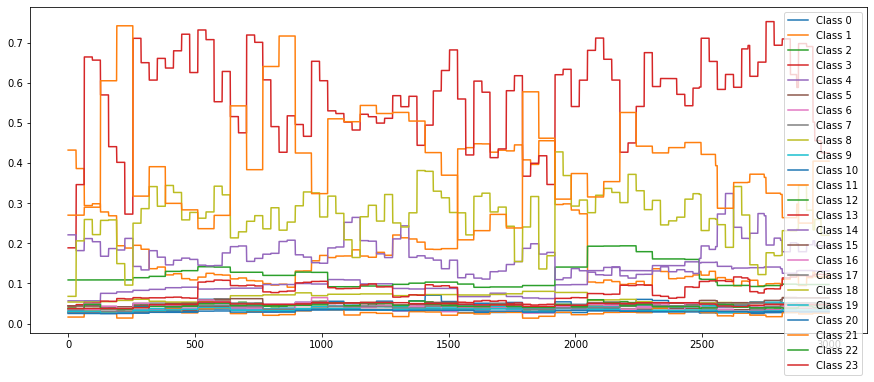

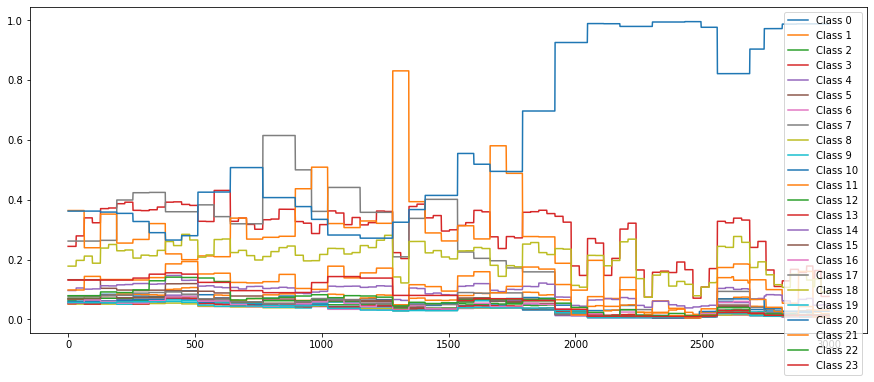

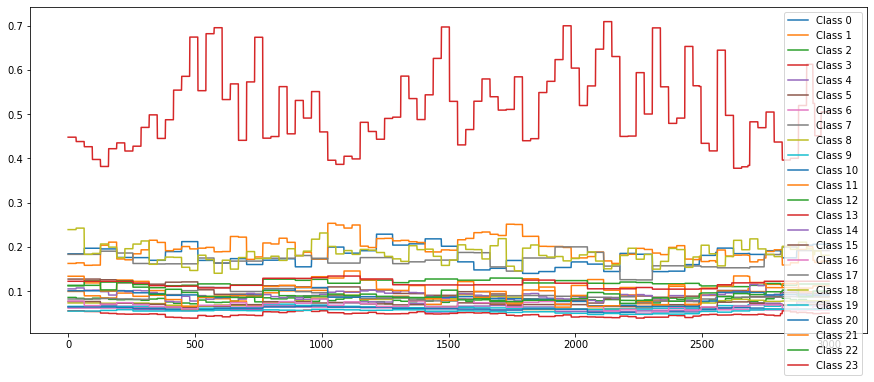

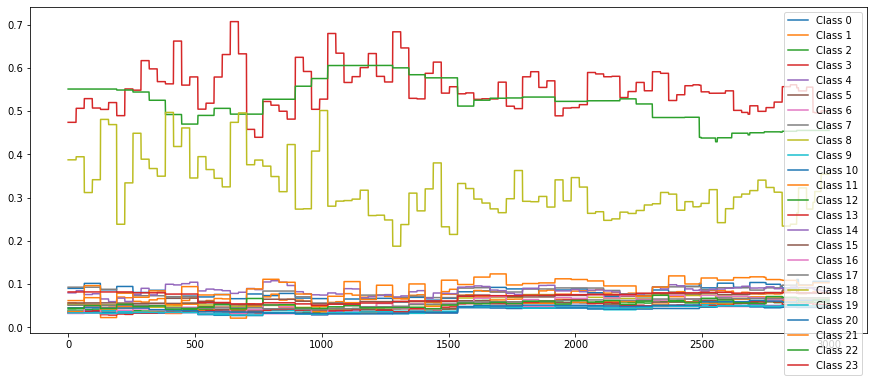

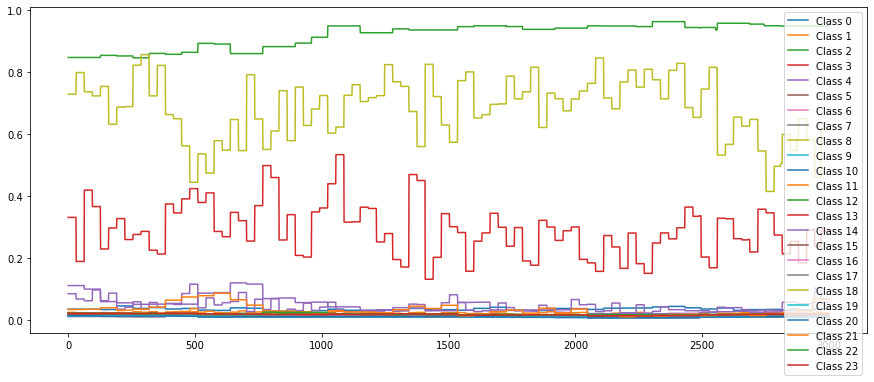

In [26]:
for i in np.random.choice(len(final_pl), 5):
    plt.figure(figsize=(15, 6))
    
    for c in range(NUM_CLASSES):
        plt.plot(final_pl[i, :, c], label=f'Class {c}')
    plt.legend()
    plt.show()

## Train

In [27]:
df_train = pd.DataFrame(os.listdir(TRAIN_MELS_PATH), columns=["recording_id"])
df_train["recording_id"] = df_train["recording_id"].apply(lambda x:x[:-4])

df_tp = pd.read_csv(DATA_PATH + "new_train_tp.csv")
recordings = list(np.unique(df_tp["recording_id"].apply(lambda x:x.split('_')[0]).values))

df_train["is_tp"] = df_train["recording_id"].apply(lambda x: x in recordings)
df_train = df_train[df_train["is_tp"] == 0]

In [30]:
for model_name, CP_FOLDER in zip(MODELS, CP_FOLDERS):
    
    print(f'\n########################\n -> Log folder : {CP_FOLDER}\n########################\n')
    
    save_folder = CP_FOLDER + "preds_train/"
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)

    for fold_idx in range(5):
        tf.keras.backend.clear_session()
        print(f"\n-------------   Fold {fold_idx + 1} / {5}  -------------\n")

        pred_agg, preds_multiscale = run_prediction(model_name, df_train, CP_FOLDER, fold_idx, root=TRAIN_MELS_PATH)

        np.save(save_folder + f"pred_agg_{fold_idx}.npy", pred_agg)
        for c, preds in enumerate(preds_multiscale):
            np.save(save_folder + f"pred_multiscale_{fold_idx}_{c}.npy", preds)


########################
 -> Log folder : ../logs/2021-02-04/9/
########################


-------------   Fold 1 / 5  -------------

29089792/29084464 [==============================] - 1s 0us/step
 -> Loading weights from ../logs/2021-02-04/9/fold0/model-0.848-0.090.h5

 -> Predicting at scale 32
 -> Predicting at scale 64
 -> Predicting at scale 128
 -> Predicting at scale 192
 -> Predicting at scale 256
 -> Predicting at scale 320
 -> Predicting at scale 384
 -> Predicting at scale 448
 -> Predicting at scale 512

 -> Aggregating predictions

-------------   Fold 2 / 5  -------------

 -> Loading weights from ../logs/2021-02-04/9/fold1/model-0.905-0.072.h5

 -> Predicting at scale 32
 -> Predicting at scale 64
 -> Predicting at scale 128
 -> Predicting at scale 192
 -> Predicting at scale 256
 -> Predicting at scale 384
 -> Predicting at scale 512

 -> Aggregating predictions

-------------   Fold 3 / 5  -------------

 -> Loading weights from ../logs/2021-02-04/9/fold2/model-0.86

 -> Loading weights from ../logs/2021-02-15/0/fold0/model-0.829-0.092.h5

 -> Predicting at scale 32
Warning, low max value.
 -> Predicting at scale 64
 -> Predicting at scale 128
 -> Predicting at scale 192
 -> Predicting at scale 256
 -> Predicting at scale 320
 -> Predicting at scale 384
 -> Predicting at scale 448
 -> Predicting at scale 512

 -> Aggregating predictions

-------------   Fold 2 / 5  -------------

 -> Loading weights from ../logs/2021-02-15/0/fold1/model-0.888-0.055.h5

 -> Predicting at scale 32
Warning, low max value.
 -> Predicting at scale 64
 -> Predicting at scale 128
 -> Predicting at scale 192
 -> Predicting at scale 256
 -> Predicting at scale 320
 -> Predicting at scale 384
 -> Predicting at scale 448
 -> Predicting at scale 512

 -> Aggregating predictions

-------------   Fold 3 / 5  -------------

 -> Loading weights from ../logs/2021-02-15/0/fold2/model-0.813-0.134.h5

 -> Predicting at scale 64
 -> Predicting at scale 128
 -> Predicting at scale 192
 

In [ ]:
preds_train = preds_to_pl(df_train, CP_FOLDER, root='preds_train')
np.save(save_folder + f"pl_train.npy", preds_train)

In [ ]:
for i in range(10):
    plt.plot(preds_train[i % 5][i])
    plt.show()